<a href="https://colab.research.google.com/github/SMPN7ButonTengah/TalagaRaya/blob/master/deteksi_pishing_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importing Libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import joblib



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Ganti dengan path ke dataset kamu
data = pd.read_csv('/content/drive/MyDrive/dataset/PhiUSIIL_Phishing_URL_Dataset.csv')

# Tampilkan beberapa baris data
print(data.head())


     FILENAME                                 URL  URLLength  \
0  521848.txt    https://www.southbankmosaics.com         31   
1   31372.txt            https://www.uni-mainz.de         23   
2  597387.txt      https://www.voicefmradio.co.uk         29   
3  554095.txt         https://www.sfnmjournal.com         26   
4  151578.txt  https://www.rewildingargentina.org         33   

                       Domain  DomainLength  IsDomainIP  TLD  \
0    www.southbankmosaics.com            24           0  com   
1            www.uni-mainz.de            16           0   de   
2      www.voicefmradio.co.uk            22           0   uk   
3         www.sfnmjournal.com            19           0  com   
4  www.rewildingargentina.org            26           0  org   

   URLSimilarityIndex  CharContinuationRate  TLDLegitimateProb  ...  Pay  \
0               100.0              1.000000           0.522907  ...    0   
1               100.0              0.666667           0.032650  ...    0   
2 

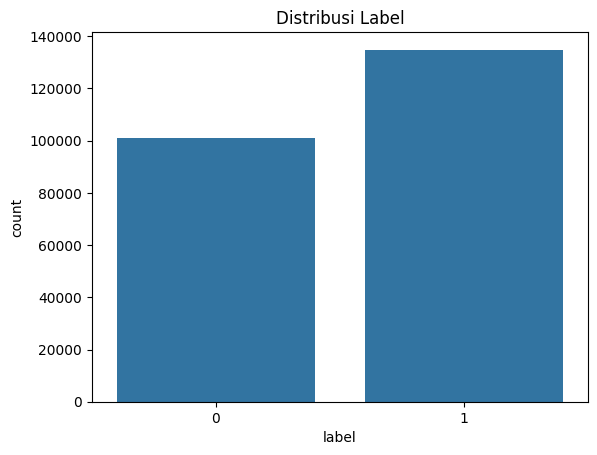

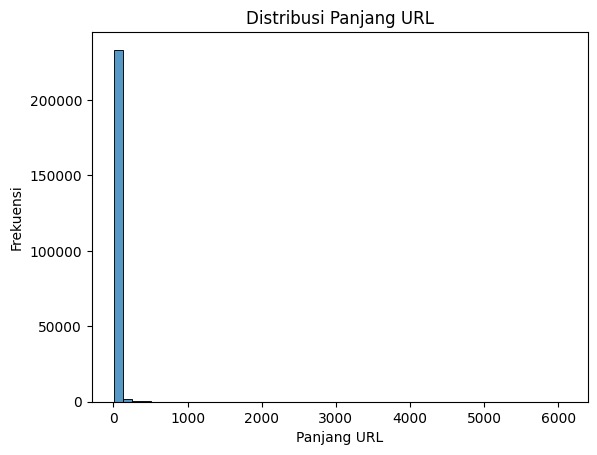

In [ ]:
# EDA: Visualisasi Distribusi Label
sns.countplot(x='label', data=data)
plt.title('Distribusi Label')
plt.show()

# EDA: Visualisasi Panjang URL
sns.histplot(data['URL'].apply(len), bins=50)
plt.title('Distribusi Panjang URL')
plt.xlabel('Panjang URL')
plt.ylabel('Frekuensi')
plt.show()

In [ ]:
# Data Preprocessing
data.dropna(inplace=True)  # Remove rows with missing values

# Ekstraksi Fitur
data['URL_length'] = data['URL'].apply(len)  # Panjang URL
data['has_https'] = data['URL'].apply(lambda x: 1 if 'https' in x else 0)  # Cek 'https'
data['has_special_char'] = data['URL'].apply(lambda x: 1 if any(char in x for char in ['@', '-', '_']) else 0)  # Karakter khusus
data['num_subdomains'] = data['URL'].apply(lambda x: x.count('.') - 1)  # Jumlah subdomain


In [ ]:
# Memilih fitur dan label
X = data[['URL_length', 'has_https', 'has_special_char', 'num_subdomains']]  # Fitur
y = data['label']  # Label


In [ ]:
# Handle Class Imbalance
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X, y)


In [ ]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)


In [ ]:
# Hyperparameter Tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
}
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Best model
model = grid_search.best_estimator_


Akurasi: 0.9313125695216907
              precision    recall  f1-score   support

           0       0.96      0.90      0.93     27023
           1       0.91      0.96      0.93     26917

    accuracy                           0.93     53940
   macro avg       0.93      0.93      0.93     53940
weighted avg       0.93      0.93      0.93     53940



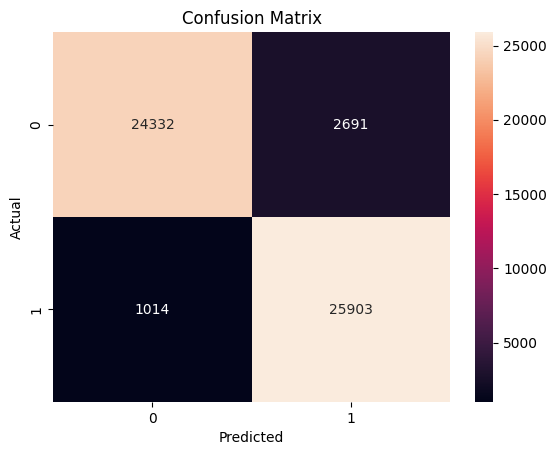

In [ ]:
# Evaluate the model
y_pred = model.predict(X_test)
print("Akurasi:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# Save the model
joblib.dump(model, 'phishing_detection_model.pkl')


['phishing_detection_model.pkl']

In [ ]:
# Fungsi untuk Prediksi
def predict_phishing(url):
    length = len(url)
    has_https = 1 if 'https' in url else 0
    has_special_char = 1 if any(char in url for char in ['@', '-', '_']) else 0
    num_subdomains = url.count('.') - 1

    features = pd.DataFrame([[length, has_https, has_special_char, num_subdomains]],
                             columns=['URL_length', 'has_https', 'has_special_char', 'num_subdomains'])

    return model.predict(features)

# Contoh prediksi
url_example = "https://www.southbankmosaics.com "
print(f"Prediksi untuk URL '{url_example}':", predict_phishing(url_example))


Prediksi untuk URL 'https://www.southbankmosaics.com ': [1]
